# Automatic Podcast Generation System

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

#LLM Model

In [5]:
import nest_asyncio
nest_asyncio.apply()

import asyncio

In [10]:
from langchain_groq import ChatGroq

async def get_llm(model: str ="llama3-70b-8192", temp: float =0, max_tokens: int=1000):
    """Loads the model from groq cloud"""
    model = ChatGroq(model=model, temperature=temp, max_tokens=max_tokens)
    return model

In [11]:
from langchain_google_genai import ChatGoogleGenerativeAI

async def podcast_model():
    """Loads LLM model to generate podcast"""

    model = ChatGoogleGenerativeAI(
            model_name="gemini-1.5-flash",
            model_kwargs={
                "temperature": 0.21,
                "top_p": 0.95,
                "top_k": 64,
                "max_output_tokens": 5000,
                "response_mime_type": "text/plain",
            },
        )
    return  model

#Graphs

##Sub-Graph

In [12]:
# subgraph state
from typing_extensions import TypedDict

class Planning(TypedDict):
    topic: str
    keywords: list[str]
    subtopics: list[str]

In [26]:
from pydantic import BaseModel, Field

class KeyWords(BaseModel):
    """Answer with atleast 5 keywords that you thik are relevant to the topic"""
    keys: list = Field(description="list of at least 5 keywords related to the topic")

get_keyword =  asyncio.run(get_llm(temp=0.1))
model_keywords = get_keyword.with_structured_output(KeyWords)

In [ ]:
#model_keywords.invoke("FineTuning")

KeyWords(keys=['FineTuning'])

In [17]:
class SubTopics(BaseModel):
    """Answer with atleast 5 subtopics related to the topic"""
    subtopics: list = Field(description="list of atleast 5 subtopics related to the topic")

class Structure(BaseModel):
    """Structure of podcast having an account of the topic and the keywords"""
    subtopics : list[SubTopics] = Field(description="5 subtopics we will review in the podcast related to the Topic and the Keyword")

podcast_structure = asyncio.run(get_llm(temp=0.3))
model_structure = podcast_structure.with_structured_output(Structure)

In [27]:
#Subgraph Functions
from langchain_core.messages import SystemMessage

async def get_keywords(state: Planning):
    """generates keywords from the given topic"""
    topic = state["topic"]
    messages = [SystemMessage(content="You task is to generate 5 relevant words about the following topic: " + topic)]
    response = await model_keywords.ainvoke(messages)
    return {"keywords": response.keys}

In [28]:
async def get_structure(state: Planning):
    """Retrieve a structured content for podcast generation with topics and keywords"""
    topic = state["topic"]
    keywords = state["keywords"]
    messages = [SystemMessage(content="You task is to generate 5 subtopics to make a podcast about the following topic: " + topic +"and the following keywords:" + " ".join(keywords))]
    response = await model_structure.ainvoke(messages)
    return {"subtopics": response.subtopics}

In [29]:
#Building SubGraph
from langgraph.graph import StateGraph, START, END

planner_build = StateGraph(Planning)

#add nodes
planner_build.add_node("KeyWords", get_keywords)
planner_build.add_node("Structure", get_structure)

#add edges
planner_build.add_edge(START, "KeyWords")
planner_build.add_edge("KeyWords", "Structure")
planner_build.add_edge("Structure", END)

plan_graph = planner_build.compile()

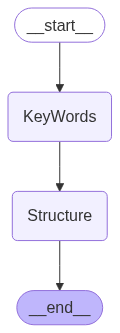

In [31]:
#Displaying SubGraph
from IPython.display import display, Image

display(Image(plan_graph.get_graph().draw_mermaid_png()))

In [32]:
await plan_graph.ainvoke({"topic": "What is Attention in human cognition"})

{'topic': 'What is Attention in human cognition',
 'keywords': ['attention', 'cognition', 'focus', 'perception', 'processing'],
 'subtopics': [SubTopics(subtopics=['The Neuroscience of Attention', 'Types of Attention', 'Attention and Perception', 'The Role of Attention in Cognitive Processing', 'Training Attention for Improved Focus'])]}

#Conduct Podcast (SubGraph)

In [33]:
from langgraph.graph import MessagesState
from typing_extensions import Annotated
import operator

class InterviewState(MessagesState):
    topic : str
    max_num_turns : int
    content: Annotated[list, operator.add]
    section: str
    sections: list


In [35]:
class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval")

podcast_groq = asyncio.run(get_llm())
structured_llm = podcast_groq.with_structured_output(SearchQuery)

In [36]:
query_instructions = """
    You are a host for popular podcast and you are tasked to interviewing an expert to learn about scientific topic.
    Your goal is to boil down to interesting and specific insights related to your topic.
    1) Interesting: Insights that people will find interesting and obvious.
    2) Specific: Insights that avoid generalities and include specific examples form the expert.
    Here is your topic of focus and set of goals: {topic}
    #
    - Begin by intorducing the topic that fits your goals, and then ask your question.
    - Continue to ask question to drill down and refine your knowledge about the topic.
    - When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help"
    Remember to stay in character throughout  the response
"""

In [37]:
async def generate_question(state: InterviewState):
    """Generates a question for podcast interview"""
    topic = state["topic"]
    messages = state["messages"]

    system_message = query_instructions.format(topic)
    question = await podcast_groq.ainvoke([SystemMessage(content=system_message)] + messages)
    return {"messages": question}

In [38]:
web_search_instructions = """
    You will be given a conversation between host of a popular podcast and an expert.
    Your goal is to genrate a well structured query for use in retrieval and / or web search related to the conversation.
    First analyze the full conversation.
    Pay particular attention to the final question posed by the host.
    Convert this question into well structured web search query.
"""

In [39]:
from langchain_community.tools.ddg_search import DuckDuckGoSearchRun

async def search_web(state: MessagesState):
    """Performs web search for relevant context"""
    search_instructions = [SystemMessage(content= web_search_instructions)]
    search_query = await structured_llm.ainvoke(search_instructions + state["messages"])

    web_search = DuckDuckGoSearchRun(max_results=3)
    search_docs = await web_search.ainvoke(search_query.search_query)

    formatted_search_docs = "\n\n--\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )
    return {"content": [formatted_search_docs]}

In [40]:
from langchain_community.document_loaders import WikipediaLoader

async def  search_wikipedia(state: InterviewState):
    """performs a wikipedia search for relevant content"""
    search_instructions = [SystemMessage(content= web_search_instructions)]
    search_query = await structured_llm.ainvoke(search_instructions + state["messages"])

    search_docs = WikipediaLoader(search_query.search_query, load_max_docs=2).load()
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )
    return {"content": [formatted_search_docs]}

In [41]:
answer_instructions = """
    You are an expert being interviewed by a popular podcast host.
    Here is the analyst's focus area: {topic}.
    Your goal is to answer a question posed by the interviewer.
    To answer the question, use this context:
    {context}
    When answering questions, follow these steps
    1. Use only the information provided in the context.
    2. Do not introduce outside information or make assumptions beyond what is explicitly stated in the context.
    3. The context includes sources on the topic of each document.
    4. Make it interesting.
"""

In [42]:
async def generate_answer(state: InterviewState):
    """Generates answers for interview questions"""
    topic = state["topic"]
    messages = state["messages"]
    context = state["content"]

    system_message = answer_instructions.format(topic, context)
    answer = await podcast_groq.ainvoke([SystemMessage(content=system_message)] + messages)

    answer.name = "expert"
    return {"messages": [answer]}

In [ ]:
from langchain_core.messages import get_buffer_string

async def save_podcast(state: InterviewState):
    """Saves the generated podcast"""
    messages = state["messages"]
    interview = await get_buffer_string(messages)
    return {"section": interview}

In [44]:
from langchain_core.messages import AIMessage

async def route_messages(state: InterviewState, name: str="expert"):
    """Route between question and answer"""
    messages = state["messages"]
    max_num_turns = state.get("max_num_turns", 2)

    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    if num_responses >= max_num_turns:
        return "Save Podcast"
    
    last_question = messages[-2]

    if "Thank you so much for your help" in last_question.content:
        return 'Save podcast'
    return "Host question"

In [45]:
section_writer_instructions = """You are an expert technical writer.

Your task is to create an interesting, easily digestible section of a podcast based on an interview.

1. Analyze the content of the interview

2. Create a script structure using markdown formatting

3. Make your title engaging based upon the focus area of the analyst:
{focus}

4. For the conversation:
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Mention turns of "Interviewer" and "Expert"
- Aim for approximately 1000 words maximum

5. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

In [46]:
async def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    section = state["section"]
    topic = state["topic"]

    system_message = section_writer_instructions.format(focus=topic)
    section_res = await  podcast_model.asend_message(system_message + f"Use this source to write your section: {section}")

    # Append it to state
    return {"sections": [section_res.text]}

In [ ]:
from langgraph.checkpoint.memory import MemorySaver

interview_builder = StateGraph(InterviewState)

#Nodes
interview_builder.add_node("Host question", generate_question)
interview_builder.add_node("Web research", search_web)
interview_builder.add_node("Wiki research", search_wikipedia)
interview_builder.add_node("Expert answer", generate_answer)
interview_builder.add_node("Save podcast", save_podcast)
interview_builder.add_node("Write script", write_section)

#add edges
interview_builder.add_edge(START, "Host question")
interview_builder.add_edge("Host question", "Web research")
interview_builder.add_edge("Host question", "Wiki research")
interview_builder.add_edge("Web research", "Expert answer")
interview_builder.add_edge("Wiki research", "Expert answer")
interview_builder.add_conditional_edges("Expert answer", route_messages,['Host question','Save podcast'])
interview_builder.add_edge("Save podcast", "Write script")
interview_builder.add_edge("Write script", END)

memory = MemorySaver()
podcast_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Create podcast")

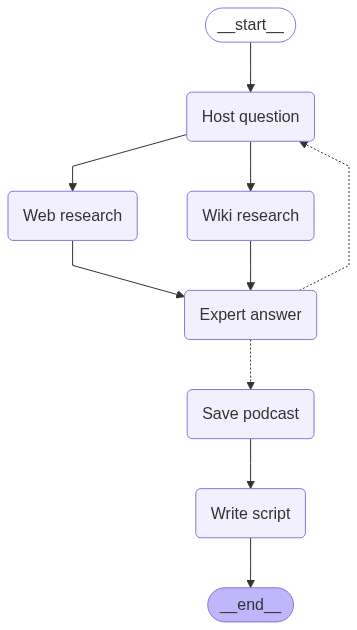

In [48]:
display(Image(podcast_graph.get_graph().draw_mermaid_png()))

In [ ]:
from langchain_core.messages import HumanMessage

messages = [HumanMessage(f"So you said you were writing an article about Attention in human cognition?")]
thread = {"configurable": {"thread_id": "1"}}
interview = await podcast_graph.ainvoke({"topic": "The Role of Focus in Perception", "messages": messages, "max_num_turns": 2}, thread)
Markdown(interview['sections'][0])

#Main Graph

In [49]:
from typing_extensions import List

class ResearchGraphState(TypedDict):
    topic: Annotated[str, operator.add] 
    keywords: List 
    max_analysts: int
    subtopics: List 
    sections: Annotated[list, operator.add]
    introduction: str 
    content: str 
    conclusion: str
    final_report: str

In [50]:
report_writer_instructions = """You are a podcast script writer preparing a script for an episode on this overall topic:

{topic}

You have a dedicated researcher who has delved deep into various subtopics related to the main theme.
Your task:

1. You will be given a collection of part of script podcast from the researcher, each covering a different subtopic.
2. Carefully analyze the insights from each script.
3. Consolidate these into a crisp and engaging narrative that ties together the central ideas from all of the script, suitable for a podcast audience.
4. Weave the central points of each script into a cohesive and compelling story, ensuring a natural flow and smooth transitions between segments, creating a unified and insightful exploration of the overall topic.

To format your script:

1. Use markdown formatting.
2. Write in a conversational and engaging tone suitable for a podcast.
3. Seamlessly integrate the insights from each script into the narrative, using clear and concise language.
4. Use transitional phrases and signposting to guide the listener through the different subtopics.

Here are the scripts from the researcher to build your podcast script from:

{context}"""

In [51]:
intro_instructions = """You are a podcast producer crafting a captivating introduction for an upcoming episode on {topic}.
You will be given an outline of the episode's main segments.
Your job is to write a compelling and engaging introduction that hooks the listener and sets the stage for the discussion.
Include no unnecessary preamble or fluff.
Target around 300 words, using vivid language and intriguing questions to pique the listener's curiosity and preview the key themes and topics covered in the episode.
Use markdown formatting.
Create a catchy and relevant title for the episode and use the # header for the title.
Use ## Introduction as the section header for your introduction.
Here are the segments to draw upon for crafting your introduction: {formatted_str_sections}"""

In [52]:
conclusion_instructions = """You are a podcast producer crafting a memorable conclusion for an episode on {topic}.
You will be given an outline of the episode's main segments.
Your job is to write a concise and impactful conclusion that summarizes the key takeaways and leaves a lasting impression on the listener.
Include no unnecessary preamble or fluff.
Target around 200 words, highlighting the most important insights and offering a thought-provoking closing statement that encourages further reflection or action.
Use markdown formatting.
Use ## Conclusion as the section header for your conclusion.
Here are the segments to draw upon for crafting your conclusion: {formatted_str_sections}"""

In [53]:
from langgraph.constants import Send

async def initiate_all_interviews(state: ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API """

    topic = state["topic"]
    return await [Send("Create podcast", {"topic": topic,
                                        "messages": [HumanMessage(
                                            content=f"So you said you were researching about {subtopic}?"
                                        )
                                                    ]}) for subtopic in state["subtopics"]]

In [54]:
async def write_report(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)
    report = await podcast_model.asend_message(system_message)
    return {"content": report.text}

In [55]:
async def write_introduction(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # Summarize the sections into a final report

    instructions = intro_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)
    intro = await podcast_model.asend_message(instructions)
    return {"introduction": intro.text}

In [56]:
async def write_conclusion(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # Summarize the sections into a final report

    instructions = conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)
    conclusion = await podcast_model.asend_message(instructions)
    return {"conclusion": conclusion.text}

In [57]:
async def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["content"]
    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]

    return {"final_report": final_report}

In [58]:
async def Start_parallel(state: ResearchGraphState):
    """ No-op node that should be interrupted on """
    pass

In [59]:
builder = StateGraph(ResearchGraphState)

builder.add_node("Planing", planner_build.compile())
builder.add_node("Start research", Start_parallel)
builder.add_node("Create podcast", interview_builder.compile())
builder.add_node("Write report",write_report)
builder.add_node("Write introduction",write_introduction)
builder.add_node("Write conclusion",write_conclusion)
builder.add_node("Finalize podcast",finalize_report)

builder.add_edge(START, "Planing")
builder.add_edge("Planing", "Start research")
builder.add_conditional_edges("Start research", initiate_all_interviews, ["Planing", "Create podcast"])
builder.add_edge("Create podcast", "Write report")
builder.add_edge("Create podcast", "Write introduction")
builder.add_edge("Create podcast", "Write conclusion")
builder.add_edge(["Write introduction", "Write report", "Write conclusion"], "Finalize podcast")
builder.add_edge("Finalize podcast", END)

memory = MemorySaver()
main_graph = builder.compile(checkpointer=memory)

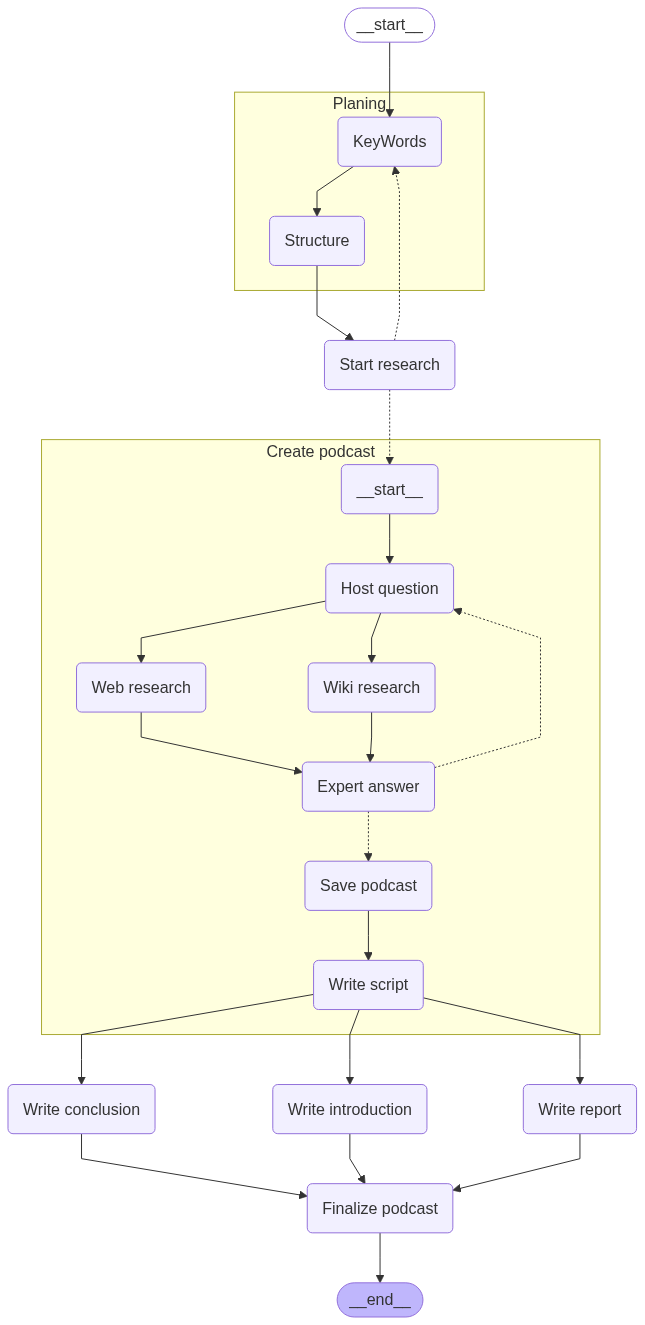

In [60]:
display(Image(main_graph.get_graph(xray=1).draw_mermaid_png()))

#TestCase

In [61]:
# Inputs
topic = "What is Attention in human cognition"

input_g = {"topic":topic}
thread = {"configurable": {"thread_id": "1"}}

In [ ]:
for event in await main_graph.astream(input_g, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [ ]:
final_state = await main_graph.aget_state(thread)
report = final_state.values.get('final_report')
display(Markdown(report))

In [ ]:
final_state.values.get('subtopics')